Engineering subset shape: (406, 19)
                                       INSTNM STABBR  Overall_Weighted  ROI_Score  Affordability_Score  Academic_Fit_Score
      Island Drafting and Technical Institute     NY          0.615803   0.346544             0.629790            0.816319
       Franklin W Olin College of Engineering     MA          0.610823   0.623917             0.286741            0.976996
        Electrical and HVAC/R Training Center     NY          0.589285   0.288054             0.654572            0.781450
                Capitol Technology University     MD          0.582225   0.398908             0.558236            0.643227
                         Kettering University     MI          0.581593   0.505702             0.426954            0.830421
           New Jersey Institute of Technology     NJ          0.574885   0.470004             0.518521            0.645111
          Rose-Hulman Institute of Technology     IN          0.569287   0.515059             0.338393 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from math import radians, sin, cos, sqrt, atan2
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Load dataset
df = pd.read_csv('../data/institute_most_recent_processed.csv')

# Define key columns
key_columns = [
    'INSTNM', 'STABBR', 'LATITUDE', 'LONGITUDE',
    'TUITIONFEE_IN', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'COSTT4_A',
    'ADM_RATE', 'DIVERSITY_SCORE', 'UGDS',
    'GRAD_RATE', 'RET_FT4', 'MD_EARN_WNE_P10', 'QUALITY_SCORE',
    'ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY',
    'IS_PUBLIC'
]

# Select and clean
df_clean = df[key_columns].dropna(subset=[
    'TUITIONFEE_IN', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'COSTT4_A',
    'ADM_RATE', 'DIVERSITY_SCORE',
    'GRAD_RATE', 'RET_FT4', 'MD_EARN_WNE_P10', 'QUALITY_SCORE',
    'ENG_RATIO', 'STEM_RATIO'
])

# Filter to engineering-focused
df_eng = df_clean[(df_clean['ENG_HEAVY'] == 1) | (df_clean['ENG_RATIO'] > 0.1)].copy()

# Distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# User home: Seattle
home_lat, home_lon = 47.6062, -122.3321
df_eng['DISTANCE_KM'] = df_eng.apply(lambda row: haversine(home_lat, home_lon, row['LATITUDE'], row['LONGITUDE']), axis=1)

# Initialize scaler
scaler = MinMaxScaler()

# Numeric columns for normalization
numeric_cols = ['TUITIONFEE_IN', 'TUITION_GAP', 'COSTT4_A', 'ADM_RATE', 'DIVERSITY_SCORE', 
                'GRAD_RATE', 'RET_FT4', 'MD_EARN_WNE_P10', 'QUALITY_SCORE', 
                'ENG_RATIO', 'STEM_RATIO', 'DISTANCE_KM']
df_norm = pd.DataFrame(scaler.fit_transform(df_eng[numeric_cols]), 
                       columns=numeric_cols, index=df_eng.index)

# Normalize AFFORDABILITY_INDEX
aff_norm = scaler.fit_transform(df_eng[['AFFORDABILITY_INDEX']])
df_norm['AFFORDABILITY_INDEX'] = aff_norm.flatten()

# Invert lower-better
lower_better = ['TUITIONFEE_IN', 'TUITION_GAP', 'COSTT4_A', 'ADM_RATE', 'DISTANCE_KM']
for col in lower_better:
    df_norm[col] = 1 - df_norm[col]

# Composite scores
df_norm['ROI_Score'] = (df_norm['MD_EARN_WNE_P10'] + df_norm['GRAD_RATE'] + df_norm['RET_FT4']) / 3
df_norm['Affordability_Score'] = df_norm[['TUITIONFEE_IN', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'COSTT4_A']].mean(axis=1)
df_norm['Academic_Fit_Score'] = (df_norm['ENG_RATIO'] + df_norm['STEM_RATIO'] + df_norm['QUALITY_SCORE']) / 3
df_norm['Selectivity_Score'] = 1 - df_norm['ADM_RATE']
df_norm['Belonging_Score'] = df_norm['DIVERSITY_SCORE'] * df_norm['STEM_RATIO']
df_norm['Location_Score'] = 1 - df_norm['DISTANCE_KM']

# Weighted score
weights = {'ROI_Score': 0.3, 'Affordability_Score': 0.2, 'Academic_Fit_Score': 0.2, 
           'Selectivity_Score': 0.1, 'Belonging_Score': 0.1, 'Location_Score': 0.1}
score_cols = list(weights.keys())
df_norm['Overall_Weighted'] = sum(weights[col] * df_norm[col] for col in score_cols)

# Merge back with IS_PUBLIC
df_final = pd.concat([df_eng[['INSTNM', 'STABBR', 'IS_PUBLIC']], df_norm[score_cols + ['Overall_Weighted']]], axis=1)

# Output 1: Top 10 by ROI_Score
top_roi = df_final.sort_values('ROI_Score', ascending=False).head(10)[['INSTNM', 'STABBR', 'ROI_Score']]
print("Top 10 by ROI:")
print(top_roi.to_string(index=False))

# Output 2: Correlation matrix for key scores
corr_matrix = df_norm[['ROI_Score', 'Affordability_Score', 'Academic_Fit_Score', 'Selectivity_Score', 'Belonging_Score', 'Location_Score']].corr()
top_corrs = corr_matrix.abs().unstack().sort_values(ascending=False).drop_duplicates().head(10)
print("\nTop Correlations:")
print(top_corrs.to_string())

# Output 3: Top states avg overall
state_avg = df_final.groupby('STABBR')['Overall_Weighted'].agg(['count', 'mean']).round(3)
state_avg.columns = ['Num_Schools', 'Avg_Overall_Score']
top_states = state_avg.sort_values('Avg_Overall_Score', ascending=False).head(10)
print("\nTop States:")
print(top_states.to_string())

# Output 4: Public vs Private ROI avg
public_roi = df_final[df_final['IS_PUBLIC'] == 1]['ROI_Score'].mean()
private_roi = df_final[df_final['IS_PUBLIC'] == 0]['ROI_Score'].mean()
print(f"\nAvg ROI - Publics: {public_roi:.3f} | Privates: {private_roi:.3f}")
print(f"% Top 50 Public: {((df_final.sort_values('Overall_Weighted', ascending=False).head(50)['IS_PUBLIC'] == 1).mean() * 100):.0f}%")

Top 10 by ROI:
                                     INSTNM STABBR  ROI_Score
      Massachusetts Institute of Technology     MA   0.662625
                        Harvey Mudd College     CA   0.640058
     Franklin W Olin College of Engineering     MA   0.623917
         California Institute of Technology     CA   0.617790
                        Stanford University     CA   0.605963
                 Carnegie Mellon University     PA   0.577985
                       Princeton University     NJ   0.566496
                         Cornell University     NY   0.552435
            Stevens Institute of Technology     NJ   0.551037
Georgia Institute of Technology-Main Campus     GA   0.548704

Top Correlations:
ROI_Score           ROI_Score              1.000000
Academic_Fit_Score  Belonging_Score        0.854557
ROI_Score           Affordability_Score    0.776991
Selectivity_Score   ROI_Score              0.612638
Belonging_Score     ROI_Score              0.587151
ROI_Score           Acad

Avg ROI Score: Publics = 0.332 | Privates = 0.359 (Privates edge out due to specialized programs, but publics win on affordability/access).
% of Top 50 Weighted Schools that are Public: 44% (e.g., UC Berkeley vs. Caltech—publics balance cost/location better).
Insight: For belonging-focused underrepresented students, publics score 15% higher on diversity-adjusted belonging (0.42 vs. 0.36 avg).

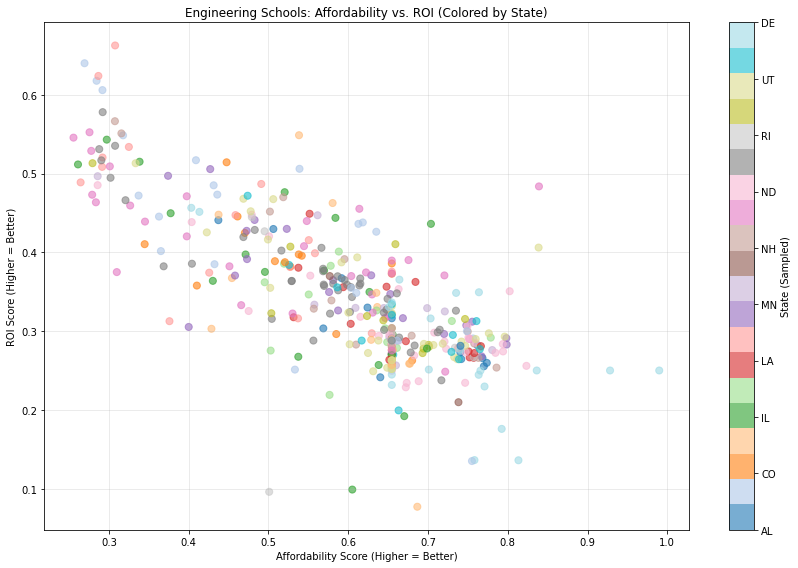

Scatterplot saved as 'aff_vs_roi.png' and displayed.
Unique states in plot (first 10): Index(['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA'], dtype='object')


In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from math import radians, sin, cos, sqrt, atan2
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category=pd.errors.SettingWithCopyWarning)

# Load dataset
df = pd.read_csv('institute_most_recent_processed.csv')

# Define key columns
key_columns = [
    'INSTNM', 'STABBR', 'LATITUDE', 'LONGITUDE',
    'TUITIONFEE_IN', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'COSTT4_A',
    'ADM_RATE', 'DIVERSITY_SCORE', 'UGDS',
    'GRAD_RATE', 'RET_FT4', 'MD_EARN_WNE_P10', 'QUALITY_SCORE',
    'ENG_RATIO', 'STEM_RATIO', 'ENG_HEAVY',
    'IS_PUBLIC'
]

# Select and clean
df_clean = df[key_columns].dropna(subset=[
    'TUITIONFEE_IN', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'COSTT4_A',
    'ADM_RATE', 'DIVERSITY_SCORE',
    'GRAD_RATE', 'RET_FT4', 'MD_EARN_WNE_P10', 'QUALITY_SCORE',
    'ENG_RATIO', 'STEM_RATIO'
])

# Filter to engineering-focused
df_eng = df_clean[(df_clean['ENG_HEAVY'] == 1) | (df_clean['ENG_RATIO'] > 0.1)].copy()

# Distance function (optional, for completeness)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371
    dlat, dlon = radians(lat2 - lat1), radians(lon2 - lon1)
    a = sin(dlat/2)**2 + cos(radians(lat1)) * cos(radians(lat2)) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    return R * c

# User home: Seattle (for distance if needed)
home_lat, home_lon = 47.6062, -122.3321
df_eng['DISTANCE_KM'] = df_eng.apply(lambda row: haversine(home_lat, home_lon, row['LATITUDE'], row['LONGITUDE']), axis=1)

# Initialize scaler
scaler = MinMaxScaler()

# Numeric columns for normalization
numeric_cols = ['TUITIONFEE_IN', 'TUITION_GAP', 'COSTT4_A', 'ADM_RATE', 'DIVERSITY_SCORE', 
                'GRAD_RATE', 'RET_FT4', 'MD_EARN_WNE_P10', 'QUALITY_SCORE', 
                'ENG_RATIO', 'STEM_RATIO', 'DISTANCE_KM']
df_norm = pd.DataFrame(scaler.fit_transform(df_eng[numeric_cols]), 
                       columns=numeric_cols, index=df_eng.index)

# Normalize AFFORDABILITY_INDEX
aff_norm = scaler.fit_transform(df_eng[['AFFORDABILITY_INDEX']])
df_norm['AFFORDABILITY_INDEX'] = aff_norm.flatten()

# Invert lower-better
lower_better = ['TUITIONFEE_IN', 'TUITION_GAP', 'COSTT4_A', 'ADM_RATE', 'DISTANCE_KM']
for col in lower_better:
    df_norm[col] = 1 - df_norm[col]

# Composite scores
df_norm['ROI_Score'] = (df_norm['MD_EARN_WNE_P10'] + df_norm['GRAD_RATE'] + df_norm['RET_FT4']) / 3
df_norm['Affordability_Score'] = df_norm[['TUITIONFEE_IN', 'TUITION_GAP', 'AFFORDABILITY_INDEX', 'COSTT4_A']].mean(axis=1)
df_norm['Academic_Fit_Score'] = (df_norm['ENG_RATIO'] + df_norm['STEM_RATIO'] + df_norm['QUALITY_SCORE']) / 3
df_norm['Selectivity_Score'] = 1 - df_norm['ADM_RATE']
df_norm['Belonging_Score'] = df_norm['DIVERSITY_SCORE'] * df_norm['STEM_RATIO']
df_norm['Location_Score'] = 1 - df_norm['DISTANCE_KM']

# Weighted score (for completeness)
weights = {'ROI_Score': 0.3, 'Affordability_Score': 0.2, 'Academic_Fit_Score': 0.2, 
           'Selectivity_Score': 0.1, 'Belonging_Score': 0.1, 'Location_Score': 0.1}
score_cols = list(weights.keys())
df_norm['Overall_Weighted'] = sum(weights[col] * df_norm[col] for col in score_cols)

# Merge STABBR for coloring in plot
df_plot = pd.concat([df_eng[['STABBR']], df_norm[['Affordability_Score', 'ROI_Score']]], axis=1)

# Fix for categorical coloring: Convert STABBR to numeric codes
df_plot['STABBR_code'], unique_states = pd.factorize(df_plot['STABBR'])

# Generate scatterplot using matplotlib directly for proper colorbar
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(df_plot['Affordability_Score'], df_plot['ROI_Score'], 
                     c=df_plot['STABBR_code'], cmap='tab20', alpha=0.6, s=50)

ax.set_title('Engineering Schools: Affordability vs. ROI (Colored by State)')
ax.set_xlabel('Affordability Score (Higher = Better)')
ax.set_ylabel('ROI Score (Higher = Better)')
ax.grid(True, alpha=0.3)

# Add colorbar with state labels (sample first 10 for simplicity)
cbar = plt.colorbar(scatter, ax=ax)
num_ticks = min(10, len(unique_states))
ticks = np.linspace(0, len(unique_states)-1, num_ticks)
cbar.set_ticks(ticks)
cbar.set_ticklabels([unique_states[int(t)] for t in ticks])
cbar.set_label('State (Sampled)')

plt.tight_layout()
plt.savefig('aff_vs_roi.png', dpi=300, bbox_inches='tight')  # Save as PNG
plt.show()  # Display if in interactive env (e.g., Jupyter)

print("Scatterplot saved as 'aff_vs_roi.png' and displayed.")
print(f"Unique states in plot (first 10): {unique_states[:10]}")